In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') # use PNG inline and PDFs when printing

# Control Of Idealized Delay+Integrator Plant
This model responds as a delay+integrator at a fixed update rate.

In [2]:
from DelayIntegratorPlantModel import DelayIntegratorPlantModel
from matplotlib import pyplot as plt

In [3]:
p = DelayIntegratorPlantModel(delay=1, gain=1, rate=1000, ambient=293, heat_leak=1)

## Plant+ Heat Leak
The plant model includes a heat leak which is the same units as the gain. A heat leak equal to the control setting will result in a constant temperature.

Show the plant cooling to the ambient temperature.

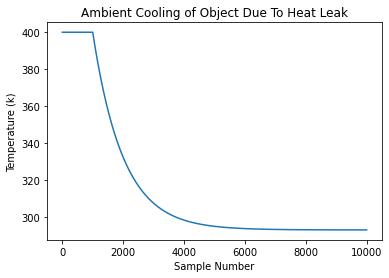

In [4]:
p.reset()
p.temperature = 400
d = []
for _ in range(10*p.delay_*p.rate_):
    d.append(p.update(0))
    
plt.plot(d)
plt.title("Ambient Cooling of Object Due To Heat Leak")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (k)")
plt.show()

## Constant Set Point
Show the plant reaching a constant temperature with different control settings. The difference will be in the temperature difference the plant rests at.

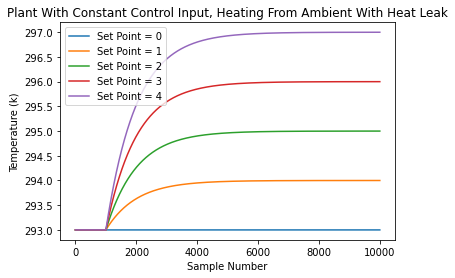

In [5]:
for set_point in range(5):
    d = []
    p.reset()
    p.temperature = p.ambient_
    for _ in range(10*p.delay_*p.rate_):
        d.append(p.update(set_point))
    
    plt.plot(d, label="Set Point = %d"%set_point)
plt.legend()
plt.title("Plant With Constant Control Input, Heating From Ambient With Heat Leak")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (k)")
plt.show()

## Idealized PI Filter
Introduce an idealized filter with no output limits. Remove the heat leak to get the ideal response. To start use the SMIC tuning algorithm (https://folk.ntnu.no/skoge/publications/2012/skogestad-improved-simc-pid/old-submitted/simcpid.pdf).

In [6]:
from PIFilter import IIR_PI_Filter, DelayIntegratorSmicTuning

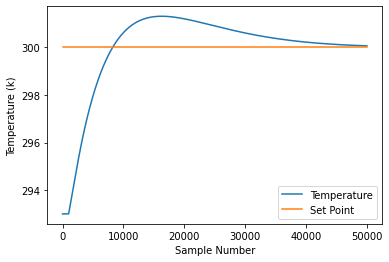

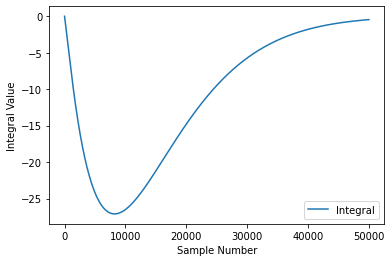

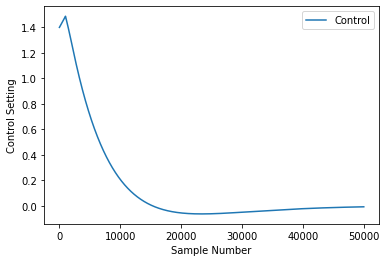

In [7]:
set_point = 300
p = DelayIntegratorPlantModel(delay=1, gain=1, rate=1000, ambient=293, heat_leak=0)
kp, ki = DelayIntegratorSmicTuning(p.delay_, p.gain_, p.rate_)
ki = ki *p.rate_
f = IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate_, set_point=set_point)


temp = []
integral = []
command = []

p.reset()
p.temperature = p.ambient_
for _ in range(50*p.delay_*p.rate_):
    control = f.update(p.temperature)
    command.append(control)
    integral.append(f.integral)
    temp.append(p.update(control))
    
plt.plot(temp, label="Temperature")
plt.plot([0, len(temp)], [set_point]*2, label="Set Point")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (k)")
plt.legend()
plt.show()

plt.plot(integral, label="Integral")
plt.xlabel("Sample Number")
plt.ylabel("Integral Value")
plt.legend()
plt.show()

plt.plot(command, label="Control")
plt.xlabel("Sample Number")
plt.ylabel("Control Setting")
plt.legend()
plt.show()



## Limited Output
The controller usually does not have unlimited current output so we need to introduce limits.
The basic implimentation just caps the output at the limit. This will cause windup of the integrator which is shown.

In [8]:
class LimitedOutputPIFilter(IIR_PI_Filter):
    def __init__(self, *args, **kwargs):
        self.ilim_ = 0
        super().__init__(*args, **kwargs)
            
    '''
    In current limit this sets the max current as set point and clears integral
    '''
    def update(self, temperature):
        set_point = super().update(temperature)
        
        current_limit = True
        if (set_point > self.ilim_):
            set_point = self.ilim_
                    
        elif (set_point < -self.ilim_):
            set_point = -self.ilim_
        return set_point

## Integrator Windup
With the limited output the integrator windsup and causes bad behaviour.

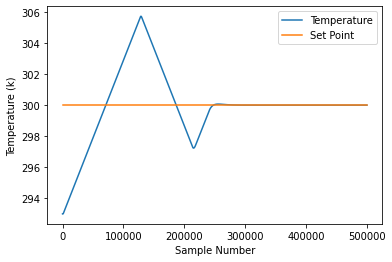

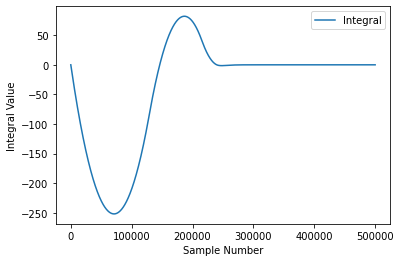

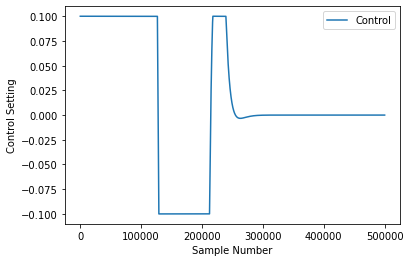

In [9]:
set_point = 300
f = LimitedOutputPIFilter(kp=kp, ki=ki, sample_time=1/p.rate_, set_point=set_point)
f.ilim_ = 0.1

temp = []
integral = []
command = []

p.reset()
p.temperature = p.ambient_
for _ in range(500*p.delay_*p.rate_):
    control = f.update(p.temperature)
    command.append(control)
    integral.append(f.integral)
    temp.append(p.update(control))
    
plt.plot(temp, label="Temperature")
plt.plot([0, len(temp)], [set_point]*2, label="Set Point")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (k)")
plt.legend()
plt.show()

plt.plot(integral, label="Integral")
plt.xlabel("Sample Number")
plt.ylabel("Integral Value")
plt.legend()
plt.show()

plt.plot(command, label="Control")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Control Setting")
plt.show()



## Anti-windup Controller
To prevent windup there are several methods that can be used of increasing complexity. The simpliest is freezing the integrator value at the point the control setting is beyond the controllers capability.

In [10]:
class LimitedAntiWindupPIFilter(IIR_PI_Filter):
    def __init__(self, *args, **kwargs):
        self.ilim_ = 0
        super().__init__(*args, **kwargs)
            
    '''
    In current limit this sets the max current as set point and clears integral
    '''
    def update(self, temperature):
        integral = self.integral_
        set_point = super().update(temperature)
        
        current_limit = True
        if (set_point > self.ilim_):
            set_point = self.ilim_
                    
        elif (set_point < -self.ilim_):
            set_point = -self.ilim_
            
        else:
            current_limit = False
        
        # dont update the integral if in current limit
        if current_limit:
            self.integral_ = integral
        return set_point

Freezing the integrator leads to less overshoot than the normal state and none of the ringing occurs.

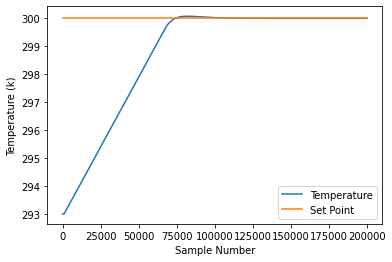

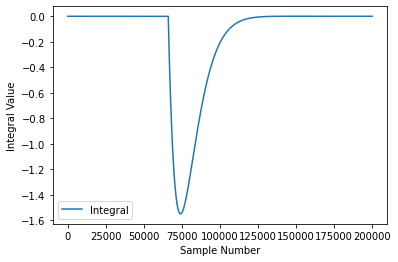

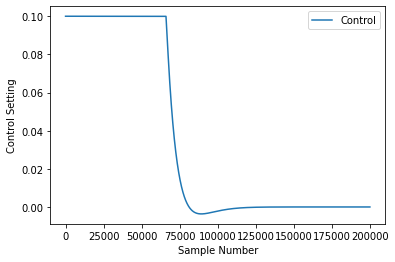

In [11]:
set_point = 300
f = LimitedAntiWindupPIFilter(kp=kp, ki=ki, sample_time=1/p.rate_, set_point=set_point)
f.ilim_ = 0.1

temp = []
integral = []
command = []

p.reset()
p.temperature = p.ambient_
for _ in range(200*p.delay_*p.rate_):
    control = f.update(p.temperature)
    command.append(control)
    integral.append(f.integral)
    temp.append(p.update(control))
    
plt.plot(temp, label="Temperature")
plt.plot([0, len(temp)], [set_point]*2, label="Set Point")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (k)")
plt.legend()
plt.show()

plt.plot(integral, label="Integral")
plt.xlabel("Sample Number")
plt.ylabel("Integral Value")
plt.legend()
plt.show()

plt.plot(command, label="Control")
plt.legend()
plt.xlabel("Sample Number")
plt.ylabel("Control Setting")
plt.show()